# Automate XPCS

In [1]:
from globus_automate_client import (create_flows_client, graphviz_format, state_colors_for_log,
                                    get_access_token_for_scope, create_action_client, 
                                    create_flows_client)
from IPython.display import display, display_svg, clear_output
from ipywidgets import widgets
import time
import json
import sys
import os

from funcx.sdk.client import FuncXClient


sys.path.append(".")
os.environ['JUPYTER_PATH'] = '.'
CLIENT_ID = "e6c75d97-532a-4c88-b031-8584a319fa3e"

## funcX

Deine the analysis and plotting functions used in the flow.

In [2]:
fxc = FuncXClient()

In [49]:
login_ep = 'cdee5fd4-7f6f-4561-a13e-d5431ef0cc8e'
theta_ep = '5e0d6d3d-3495-4a3e-a44b-6e22731e25f6'
local_ep = '4a308ac0-1b73-4196-8a7d-792427901f0f'

In [27]:
def alcf_xpcs_corr(event):
    import time
    import json
    import subprocess
    from subprocess import PIPE
    
    print("Starting XPCS Corr")
    
    hdf_file = event['data']['hdf']
    imm_file = event['data']['imm']
    
    cmd = f"/soft/datascience/xpcs_eigen/build/corr {hdf_file} -imm {imm_file}"
    cmd = cmd.split(" ")
    
    res = subprocess.run(cmd, stdout=PIPE, stderr=PIPE)
    print(res.stdout)
    print(res.stderr)
    return str(res.stdout)

alcf_xpcs_corr_func_uuid = fxc.register_function(alcf_xpcs_corr, description="An XPCS corr function.")
print(alcf_xpcs_corr_func_uuid)

5c391f5a-4203-43d7-a50b-3f2a16f82b72


In [28]:
def plot_xpcs(event):
    import os
    import time
    import json
    import shutil
    import pickle
    import subprocess
    from subprocess import PIPE
    
    hdf_file = event['data']['hdf']
    hdf_file_name = hdf_file.split("/")[-1]
    exp_name = ".".join(hdf_file.split("/")[-1].split(".")[:-1])
    
    dir_name = "/".join(hdf_file.split('/')[:-1])

    os.chdir(dir_name)
    
    python = '/home/rchard/.conda/envs/funcx-theta/bin/python'
    xpcs_plot = '/home/rchard/APSDataAnalysis/tools/pilot1-tools/scripts/xpcs_plots.py'
    xpcs_meta = '/home/rchard/APSDataAnalysis/tools/pilot1-tools/scripts/xpcs_metadata.py'
    xpcs_qc = '/home/rchard/APSDataAnalysis/tools/pilot1-tools/scripts/xpcs_qc.py'

    cmd = f"{python} {xpcs_plot} {hdf_file}"
    print(cmd)
    cmd = cmd.split(" ")
    res = subprocess.run(cmd, stdout=PIPE, stderr=PIPE)
    print(res.stdout)
    
    cmd = f"{python} {xpcs_meta} gather {hdf_file}"
    print(cmd)
    
    my_env = os.environ.copy()
    my_env["LC_ALL"] = "C.UTF-8"
    my_env["LANG"] = "C.UTF-8"
    
    cmd = cmd.split(" ")
    res = subprocess.run(cmd, stdout=PIPE, stderr=PIPE, env=my_env)
    print(res.stdout)
    print(res.stderr) 
    return str(res.stderr)
    return cmd
    return 'done'

plot_xpcs_func_uuid = fxc.register_function(plot_xpcs, description="An XPCS corr function.")
print(plot_xpcs_func_uuid)

1e4c9994-1440-4aee-a719-78d0e6d1f604


In [41]:
def alcf_xpcs_pilot(event):
    import time
    import json
    import subprocess
    from subprocess import PIPE
    
    print("Starting XPCS Pilot")
    
    meta_file = event['data']['metadata']
    exp_name = event['data']['hdf'].split("/")[-1].replace(".hdf", "")
    
    pilot = '/home/rchard/.conda/envs/funcx-theta/bin/pilot'

    cmd = f"{pilot} upload -u -j {meta_file} {exp_name} /"
    print(cmd)
    
    res = subprocess.run(cmd.split(" "), stdout=PIPE, stderr=PIPE,
    env={'LC_ALL': 'C.UTF-8', 'LANG': 'C.UTF-8'})
    
    print(res.stdout)
    print(res.stderr)
    return str(res.stdout)

pilot_func_uuid = fxc.register_function(alcf_xpcs_pilot, description="An XPCS pilot function.")
print(pilot_func_uuid)

ac0e05bf-e04a-4d43-9f73-1f05db0075e2


## Automate XPCS

Combine using the functions with Automate to first transfer data to Theta, use funcX, then return the result.

In [29]:
# This flow does not return the result to APS.

flow_definition = {
  "Comment": "Automate XPCS",
  "StartAt": "Transfer1",
  "States": {
    "Transfer1": {
      "Comment": "Initial Transfer from APS to ALCF",
      "Type": "Action",
      "ActionUrl": "https://actions.automate.globus.org/transfer/transfer",
      "ActionScope": "https://auth.globus.org/scopes/actions.globus.org/transfer/transfer",
      "InputPath": "$.Transfer1Input",
      "ResultPath": "$.Transfer1Result",
      "WaitTime": 6000,
      "Next": "Transfer2"
    },
    "Transfer2": {
      "Comment": "Second Transfer from APS to ALCF",
      "Type": "Action",
      "ActionUrl": "https://actions.automate.globus.org/transfer/transfer",
      "ActionScope": "https://auth.globus.org/scopes/actions.globus.org/transfer/transfer",
      "InputPath": "$.Transfer2Input",
      "ResultPath": "$.Transfer2Result",
      "WaitTime": 6000,
      "Next": "ExecCorr"
    },
    "ExecCorr": {
      "Comment": "Use corr to process the data",
      "Type": "Action",
      "ActionUrl": "https://dev.funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec1Input",
      "ResultPath": "$.Exec1Result",
      "WaitTime": 12000,
      "Next": "ExecPlots"
    },
    "ExecPlots": {
      "Comment": "Generate plots from the data",
      "Type": "Action",
      "ActionUrl": "https://dev.funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec2Input",
      "ResultPath": "$.Exec2Result",
      "WaitTime": 12000,
      "Next": "ExecPilot"
    },
    "ExecPilot": {
      "Comment": "Generate plots from the data",
      "Type": "Action",
      "ActionUrl": "https://funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec3Input",
      "ResultPath": "$.Exec3Result",
      "WaitTime": 12000,
      "End": True
    }
  }
}

In [37]:
# This flow does not return the result to APS.

flow_definition = {
  "Comment": "Automate XPCS",
  "StartAt": "ExecCorr",
  "States": {
    "ExecCorr": {
      "Comment": "Use corr to process the data",
      "Type": "Action",
      "ActionUrl": "https://dev.funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec1Input",
      "ResultPath": "$.Exec1Result",
      "WaitTime": 12000,
      "Next": "ExecPlots"
    },
    "ExecPlots": {
      "Comment": "Generate plots from the data",
      "Type": "Action",
      "ActionUrl": "https://dev.funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec2Input",
      "ResultPath": "$.Exec2Result",
      "WaitTime": 12000,
      "Next": "ExecPilot"
    },
    "ExecPilot": {
      "Comment": "Generate plots from the data",
      "Type": "Action",
      "ActionUrl": "https://funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec3Input",
      "ResultPath": "$.Exec3Result",
      "WaitTime": 12000,
      "End": True
    }
  }
}

In [38]:
flows_client = create_flows_client(CLIENT_ID)
flow = flows_client.deploy_flow(flow_definition, title="XPCS")
from pprint import pprint
pprint(flow)
flow_id = flow.data['id']
print(flow)
flow_scope = flow['globus_auth_scope']
print(f'Newly created flow with id:\n{flow_id}\nand scope:\n{flow_scope}')

GlobusHTTPResponse({'administered_by': [], 'api_version': '1.0', 'definition': {'Comment': 'Automate XPCS', 'StartAt': 'ExecCorr', 'States': {'ExecCorr': {'ActionScope': 'https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2', 'ActionUrl': 'https://dev.funcx.org/automate', 'Comment': 'Use corr to process the data', 'InputPath': '$.Exec1Input', 'Next': 'ExecPlots', 'ResultPath': '$.Exec1Result', 'Type': 'Action', 'WaitTime': 12000}, 'ExecPilot': {'ActionScope': 'https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2', 'ActionUrl': 'https://funcx.org/automate', 'Comment': 'Generate plots from the data', 'End': True, 'InputPath': '$.Exec3Input', 'ResultPath': '$.Exec3Result', 'Type': 'Action', 'WaitTime': 12000}, 'ExecPlots': {'ActionScope': 'https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2', 'ActionUrl': 'https://dev.funcx.org/automate', 'Comment': 'Generate plots from the data', 'InputPath': '$.Exec2Input', 'Nex

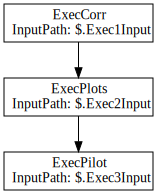

In [39]:
get_resp = flows_client.get_flow(flow_id)
flow_def = get_resp.data['definition']
flow_graph = graphviz_format(flow_def)
display(flow_graph)

Define a function to serialize inputs for funcX

In [33]:
def serialize_fx_inputs(*args, **kwargs):
    from funcx.serialize import FuncXSerializer
    fx_serializer = FuncXSerializer()
    ser_args = fx_serializer.serialize(args)
    ser_kwargs = fx_serializer.serialize(kwargs)
    payload = fx_serializer.pack_buffers([ser_args, ser_kwargs])
    return payload

In [40]:
event = {"data": {
         "hdf": "/projects/APSDataAnalysis/Automate/A001_Aerogel_1mm_att6_Lq0_001_0001-1000.hdf",
         "imm": "/projects/APSDataAnalysis/Automate/A001_Aerogel_1mm_att6_Lq0_001_00001-01000.imm",
         "metadata": "/projects/APSDataAnalysis/Automate/A001_Aerogel_1mm_att6_Lq0_001_0001-1000.json"
     }}
funcx_payload = serialize_fx_inputs(event=event)
print(funcx_payload)

12
01
gAMpLg==
316
01
gAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWE4AAAAvcHJvamVj
dHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL0EwMDFfQWVyb2dlbF8xbW1fYXR0Nl9McTBfMDAx
XzAwMDEtMTAwMC5oZGZxBlgDAAAAaW1tcQdYUAAAAC9wcm9qZWN0cy9BUFNEYXRhQW5hbHlzaXMv
QXV0b21hdGUvQTAwMV9BZXJvZ2VsXzFtbV9hdHQ2X0xxMF8wMDFfMDAwMDEtMDEwMDAuaW1tcQh1
c3Mu

12
01
gAMpLg==
194
01
gAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBFgIAAAAbWV0YWRhdGFxBVhPAAAAL3By
b2plY3RzL0FQU0RhdGFBbmFseXNpcy9BdXRvbWF0ZS9BMDAxX0Flcm9nZWxfMW1tX2F0dDZfTHEw
XzAwMV8wMDAxLTEwMDAuanNvbnEGc3NzLg==



In [42]:
flow_input = {
  "Transfer1Input": {
    "source_endpoint_id": "b0e921df-6d04-11e5-ba46-22000b92c6ec",
    "destination_endpoint_id": "08925f04-569f-11e7-bef8-22000b9a448b",
    "transfer_items": [
      {
        "source_path": "/data/xpcs8/2019-1/comm201901/cluster_results/A001_Aerogel_1mm_att6_Lq0_001_0001-1000.hdf",
        "destination_path": "/projects/APSDataAnalysis/Automate/A001_Aerogel.hdf",
        "recursive": False
      }
    ]
  },
  "Transfer2Input": {
    "source_endpoint_id": "b0e921df-6d04-11e5-ba46-22000b92c6ec",
    "destination_endpoint_id": "08925f04-569f-11e7-bef8-22000b9a448b",
    "transfer_items": [
      {
        "source_path": "/data/xpcs8/2019-1/comm201901/A001_Aerogel_1mm_att6_Lq0_001/A001_Aerogel_1mm_att6_Lq0_001_00001-01000.imm",
        "destination_path": "/projects/APSDataAnalysis/Automate/A001_Aerogel.imm",
        "recursive": False
      }
    ]
  },
  "Exec1Input": {
    "endpoint":theta_ep,
     "func":alcf_xpcs_corr_func_uuid,
     "payload": funcx_payload
  },
  "Exec2Input": {
    "endpoint":theta_ep,
     "func":plot_xpcs_func_uuid,
     "payload": funcx_payload
  },
  "Exec3Input": {
      "endpoint": login_ep,
      "func": pilot_func_uuid,
      "payload": funcx_payload
  }
}


In [45]:
flow_action = flows_client.run_flow(flow_id, flow_scope, flow_input)
print(flow_action)
flow_action_id = flow_action['action_id']
flow_status = flow_action['status']
print(f'Flow action started with id: {flow_action_id}')
while flow_status == 'ACTIVE':
    time.sleep(10)
    flow_action = flows_client.flow_action_status(flow_id, flow_scope, flow_action_id)
    flow_status = flow_action['status']
    print(f'Flow status: {flow_status}')

GlobusHTTPResponse({'action_id': 'af373502-324e-4cdc-8c86-d5d50f606379', 'completion_time': 'None', 'created_by': 'urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf', 'details': {'code': 'ActionStarted', 'description': 'State ExecCorr of type Action started', 'details': {'input': {'Exec1Input': {'endpoint': '5e0d6d3d-3495-4a3e-a44b-6e22731e25f6', 'func': '5c391f5a-4203-43d7-a50b-3f2a16f82b72', 'payload': '12\n01\ngAMpLg==\n316\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWE4AAAAvcHJvamVj\ndHMvQVBTRGF0YUFuYWx5c2lzL0F1dG9tYXRlL0EwMDFfQWVyb2dlbF8xbW1fYXR0Nl9McTBfMDAx\nXzAwMDEtMTAwMC5oZGZxBlgDAAAAaW1tcQdYUAAAAC9wcm9qZWN0cy9BUFNEYXRhQW5hbHlzaXMv\nQXV0b21hdGUvQTAwMV9BZXJvZ2VsXzFtbV9hdHQ2X0xxMF8wMDFfMDAwMDEtMDEwMDAuaW1tcQh1\nc3Mu\n'}, 'Exec2Input': {'endpoint': '5e0d6d3d-3495-4a3e-a44b-6e22731e25f6', 'func': '1e4c9994-1440-4aee-a719-78d0e6d1f604', 'payload': '12\n01\ngAMpLg==\n316\n01\ngAN9cQBYBQAAAGV2ZW50cQF9cQJYBAAAAGRhdGFxA31xBChYAwAAAGhkZnEFWE4AAAAvcHJvamVj

### Testing Pilot ingest

Need to figure out either using -s or renaming the directory the data is being processed in. Perhaps easiest if we just force everything to be worked on in the experiment name dir? then do a chdir to that exp?

In [76]:
def alcf_xpcs_pilot(event):
    import time
    import json
    import subprocess
    from subprocess import PIPE
    
    print("Starting XPCS Pilot")
    
    meta_file = event['data']['metadata']
    exp_name = event['data']['hdf'].split("/")[-1].replace(".hdf", "")
    
    pilot = '/home/rchard/.conda/envs/funcx-theta/bin/pilot'

    cmd = f"{pilot} upload -u -j {meta_file} {exp_name} /"
    print(cmd)
    
    res = subprocess.run(cmd.split(" "), stdout=PIPE, stderr=PIPE,
    env={'LC_ALL': 'C.UTF-8', 'LANG': 'C.UTF-8'})
    
    print(res.stdout)
    print(res.stderr)
    return str(res.stdout)

pilot_func_uuid = fxc.register_function(alcf_xpcs_pilot, description="An XPCS pilot function.")
print(pilot_func_uuid)

7b80f14a-981d-4d8a-bf63-06b9cf9201e7


In [77]:
event = {"data": {
         "hdf": "/projects/APSDataAnalysis/Automate/A001_Aerogel_1mm_att6_Lq0_001_0001-1000.hdf",
         "imm": "/projects/APSDataAnalysis/Automate/A001_Aerogel_1mm_att6_Lq0_001_00001-01000.imm",
         "metadata": "/projects/APSDataAnalysis/Automate/A001_Aerogel_1mm_att6_Lq0_001_0001-1000.json"
     }}
res = fxc.run(event, endpoint_id=login_ep, function_id=pilot_func_uuid)
print(res)

2cb51d39-35b5-40a3-98bc-ebe0e20482ec


In [78]:
print(fxc.get_result(res))

/home/rchard/.conda/envs/funcx-theta/bin/pilot upload -u -j /projects/APSDataAnalysis/Automate/A001_Aerogel_1mm_att6_Lq0_001_0001-1000.json A001_Aerogel_1mm_att6_Lq0_001_0001-1000 /


In [61]:
from funcx.serialize import FuncXSerializer
fx_serializer = FuncXSerializer()
# res = '01\ngANYAwAAAGInJ3EALg==\n'

x = fx_serializer.deserialize(res)
x

Exception: Invalid header: b06 in data payload

### Nick testing

In [ ]:
def process_hdf(event):
    import os
    import shutil
    from XPCS.scripts.xpcs_metadata import gather
    from XPCS.scripts.xpcs_plots import make_plots
    from XPCS.scripts.xpcs_qc import check_hdf_dataset
    from pilot.client import PilotClient

    hdf_file = event['data']['hdf']
    hdf_dir, extension = os.path.splitext(hdf_file)
    try:
        os.mkdir(hdf_dir)
        shutil.move(hdf_file, hdf_dir)
    except Exception as e:
        print(e)
    hdf_file = os.path.join(hdf_dir, os.path.basename(hdf_file))
    os.chdir(hdf_dir)
    assert os.path.exists(hdf_file), 'HDF File {hdf_file} does not exist!'

    if check_hdf_dataset(hdf_file) is False:
        print('HDF Check failed, skipping...')
        return {}
    metadata = gather(hdf_file)
    make_plots(hdf_file)
    metadata.update(event['custom_metadata'])
    pc = PilotClient()
    uploaded_metadata = pc.register(hdf_dir, '/', metadata=metadata,
                                    update=True, skip_analysis=True)
    print('Everything worked, register called')
    return uploaded_metadata

In [ ]:
process_hdf_func_uuid = fxc.register_function(
    process_hdf, description="Put hdf file into dir, make plots, gather metadata."
)
print(process_hdf_func_uuid)

In [ ]:
fname = '/Users/nick/globus/aps/globus-automation/XPCS/data/A001_Aerogel_1mm_att3_Lq0_001_0001-1000.hdf'
payload = {
    'data': {
        "hdf": f"{fname}"
    },
    'custom_metadata': {
        "description": f"{fname}: Automated data processing.",
        "creators": [{"creatorName": "8-ID"}],
        "publisher": "Automate",
        "title": fname,
        "subjects": [{"subject": "XPCS"}, {"subject": "8-ID"}],
        "publicationYear": "2019",
        "resourceType": {
            "resourceType": "Dataset",
            "resourceTypeGeneral": "Dataset"
        }
    }
}
res = fxc.run(payload, endpoint_id=local_ep, function_id=process_hdf_func_uuid)
print(res)

In [ ]:
print(res)
fxc.get_result(res)